In [42]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import requests
import json

def pass_web(team,ssn,web):

    ### the 'team' parameter takes in an nba team's three letter abbreviation. 'GSW' for the golden state warriors, for example
    ### the 'ssn' parameter takes in an nba season (2013-14 at the earliest). '2015-16' for example
    ### the 'web' parameter takes in 'AST' or 'pass' (or other variations of the two).
    ### the 'web' parameter exists because you can create networks in which the lines represent either assists or passes -- the parameter is used to tell which one of the two you'd like to do
    ### example of usage: pass_web('GSW','2016-17','AST')

    if (web in ['ast','AST','assist','assists','assisting','ASSIST','ASSISTS']):
        web = 'assist'
    elif (web in ['pass','passes','passing','PASS','PASSES']):
        web = 'pass'
    else:
        return print('Error: Third parameter requires "assist" or "pass" input')

    headers = {'Host': 'stats.nba.com','Accept': 'application/json, text/plain, */*','x-nba-stats-token': 'true','User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Mobile Safari/537.36','x-nba-stats-origin': 'stats','Origin': 'https://www.nba.com','Referer': 'https://www.nba.com/','Accept-Encoding': 'gzip, deflate, br','Accept-Language': 'en-US,en;q=0.9}'}
    ### scrape stats.nba.com to find the team_id for the inputted team
    print("Retrieving from NBA Stats URL...")
    url = 'https://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=PerGame&Period=0&PlayerExperience=&PlayerOrTeam=Team&PlayerPosition=&PtMeasureType=Drives&Season=' + str(ssn) + '&SeasonSegment=&SeasonType=Regular+Season&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight='

    json = requests.get(url, headers=headers).json()
    print("Data retrieved...")
    data = json['resultSets'][0]['rowSet']
    columns = json['resultSets'][0]['headers']

    tms = pd.DataFrame.from_records(data, columns=columns)
    team_id = tms[tms.TEAM_ABBREVIATION == team].reset_index(drop=True).TEAM_ID[0]
    team_name = tms[tms.TEAM_ABBREVIATION == team].reset_index(drop=True).TEAM_NAME[0]

    ### using the scraped team_id, find all players who accumulated at least 10 assists with that team in the inputted season

    url = 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=' + str(ssn) + '&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=' + str(team_id) + '&TwoWay=0&VsConference=&VsDivision=&Weight='

    json = requests.get(url, headers=headers).json()

    data = json['resultSets'][0]['rowSet']
    columns = json['resultSets'][0]['headers']

    df = pd.DataFrame.from_records(data, columns=columns)

    df = df[df.AST > 10]

    players = df.PLAYER_ID.unique()

    ### using the players previously found, record all of their pass connections while on the team

    df_list = []

    for x in players:

        url = 'https://stats.nba.com/stats/playerdashptpass?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=Totals&Period=0&PlayerID=' + str(x) + '&Season=' + str(ssn) + '&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision='

        json = requests.get(url, headers=headers).json()

        data = json['resultSets'][0]['rowSet']
        columns = json['resultSets'][0]['headers']

        df_list.append(pd.DataFrame.from_records(data, columns=columns))

    df = pd.concat(df_list)

    df = df[['TEAM_ABBREVIATION','PLAYER_NAME_LAST_FIRST','PASS_TO','PASS','AST']]
    df.columns = ['tm','passer','receiver','passes','ast']

    ### clean up the format for the name

    def fix_name(name):
        if ',' in name:
            return name.split(", ")[1][:1] + "." + name.split(", ")[0]
        else:
            return name
    df.passer = np.vectorize(fix_name)(df.passer)
    df.receiver = np.vectorize(fix_name)(df.receiver)

    df = df[df.receiver.isin(df.passer.unique())].reset_index(drop=True)

    players = df.passer.unique()

    ### making list with assist totals for each player (will be used as input for node size)

    ast_list = []
    for x in players:
        tf = df[df.passer == x].reset_index(drop=True)
        ast_list.append(tf.ast.sum())

    ### creating adjacency matrix

    adf = pd.DataFrame(index=players,columns=players)

    adf.values[[np.arange(adf.shape[0])]*2] = 0

    if web == 'pass':
        for x in players:
            for y in range(0,len(players)):
                tf1 = df[(df.passer == x) & (df.receiver == adf.columns[y])].reset_index(drop=True)
                tf2 = df[(df.passer == adf.columns[y]) & (df.receiver == x)].reset_index(drop=True)
                if (tf1.shape[0] == 1) & (tf2.shape[0] == 0):
                    adf.at[x,adf.columns[y]] = tf1.passes[0]
                elif (tf1.shape[0] == 0) & (tf2.shape[0] == 1):
                    adf.at[x,adf.columns[y]] = tf2.passes[0]
                elif (tf1.shape[0] == 1) & (tf2.shape[0] == 1):
                    adf.at[x,adf.columns[y]] = tf1.passes[0] + tf2.passes[0]
                else:
                    adf.at[x,adf.columns[y]] = 0

    else:
        for x in players:
            for y in range(0,len(players)):
                tf1 = df[(df.passer == x) & (df.receiver == adf.columns[y])].reset_index(drop=True)
                tf2 = df[(df.passer == adf.columns[y]) & (df.receiver == x)].reset_index(drop=True)
                if (tf1.shape[0] == 1) & (tf2.shape[0] == 0):
                    adf.at[x,adf.columns[y]] = tf1.ast[0]
                elif (tf1.shape[0] == 0) & (tf2.shape[0] == 1):
                    adf.at[x,adf.columns[y]] = tf2.ast[0]
                elif (tf1.shape[0] == 1) & (tf2.shape[0] == 1):
                    adf.at[x,adf.columns[y]] = tf1.ast[0] + tf2.ast[0]
                else:
                    adf.at[x,adf.columns[y]] = 0

    ### graphing the network
    print(adf.values)
    plt.figure(figsize=(4,4))

    G = nx.from_numpy_array(np.array(adf.values, dtype=int), parallel_edges=True)

    d = dict(G.degree)

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    pos = nx.circular_layout(G)

    labeldict = {}
    for n in range(0,len(adf.index)):
        labeldict[n] = adf.index[n]

    edge_widths = [weight * 0.02 for weight in weights]

    # If visualizing passing network, the scale factor should be further downweighted
    if web == "pass":
        edge_widths = [weight * 0.005 for weight in weights]


    nx.draw_circular(G,labels=labeldict,with_labels=False, nodelist=d.keys(), node_size=[v for v in ast_list],linewidths=2, edgelist=edges, edge_color=weights, width=edge_widths, edge_cmap=plt.cm.binary, node_color='white')
    # Adjust label positions to be outside the circular layout
    label_pos = {}
    offset = 1.12  # Adjust this value to control how far the labels are from the nodes
    for key, (x, y) in pos.items():
        label_pos[key] = (x * offset, y * offset)

    # Draw the labels
    nx.draw_networkx_labels(G, pos=label_pos, labels=labeldict)

    # Get the top 10 edges by weight
    edges_with_weights = [(u, v, w) for u, v, w in G.edges(data='weight')]
    top_20_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)[:20]

    # Create a dictionary for edge labels with only the top 10 edges
    top_20_edge_labels = {(u, v): w for u, v, w in top_20_edges}

    # Draw the edge labels for the top 10 edges
    nx.draw_networkx_edge_labels(G, pos=nx.circular_layout(G), edge_labels=top_20_edge_labels)


    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000")

    if web == 'pass':
        plt.title(ssn + ' ' + team_name + ' Passing Network')
    else:
        plt.title(ssn + ' ' + team_name + ' Assist Network')

    yr = ssn[:2] + ssn[5:] # converts '2016-17' to '2017', for instance
    plt.savefig(team + yr + web  + '.svg',dpi=600,bbox_inches='tight')

Retrieving from NBA Stats URL...
Data retrieved...


/var/folders/ds/8n3t559534xdjhwy7xq1h9nm0000gn/T/ipykernel_21504/2781744549.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


[[0 0 62 59 81 39 16 7 1 3 44 26 0 2]
 [0 0 1 1 2 0 0 1 2 3 5 5 3 0]
 [62 1 0 124 117 84 100 34 4 3 32 31 2 5]
 [59 1 124 0 74 100 93 12 4 10 28 31 2 2]
 [81 2 117 74 0 117 99 17 3 8 46 47 6 3]
 [39 0 84 100 117 0 71 20 5 4 37 32 2 7]
 [16 0 100 93 99 71 0 2 0 1 23 15 0 2]
 [7 1 34 12 17 20 2 0 3 8 40 11 9 0]
 [1 2 4 4 3 5 0 3 0 2 19 4 6 0]
 [3 3 3 10 8 4 1 8 2 0 33 9 7 1]
 [44 5 32 28 46 37 23 40 19 33 0 79 33 16]
 [26 5 31 31 47 32 15 11 4 9 79 0 6 7]
 [0 3 2 2 6 2 0 9 6 7 33 6 0 2]
 [2 0 5 2 3 7 2 0 0 1 16 7 2 0]]


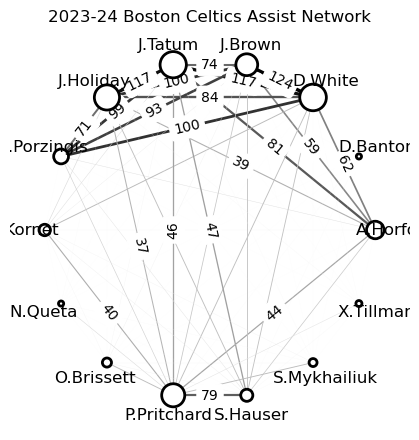

In [40]:
pass_web('BOS','2023-24','AST')

Retrieving from NBA Stats URL...
Data retrieved...


/var/folders/ds/8n3t559534xdjhwy7xq1h9nm0000gn/T/ipykernel_21504/914915468.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


[[0 1 2 1 10 3 8 2 10 1 8 18 1 3]
 [1 0 1 7 60 14 28 90 103 21 64 18 18 7]
 [2 1 0 1 0 0 1 2 0 0 0 2 0 1]
 [1 7 1 0 0 17 3 15 14 0 11 6 1 0]
 [10 60 0 0 0 0 26 45 55 33 30 6 30 10]
 [3 14 0 17 0 0 13 22 35 0 16 25 7 0]
 [8 28 1 3 26 13 0 37 47 16 37 20 11 5]
 [2 90 2 15 45 22 37 0 70 21 129 25 65 9]
 [10 103 0 14 55 35 47 70 0 21 165 44 71 11]
 [1 21 0 0 33 0 16 21 21 0 16 16 6 0]
 [8 64 0 11 30 16 37 129 165 16 0 10 78 8]
 [18 18 2 6 6 25 20 25 44 16 10 0 10 7]
 [1 18 0 1 30 7 11 65 71 6 78 10 0 7]
 [3 7 1 0 10 0 5 9 11 0 8 7 7 0]]


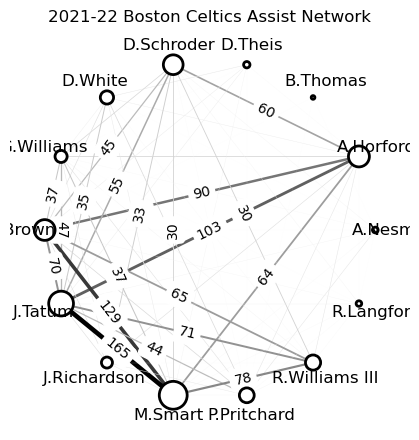

In [33]:
pass_web('BOS','2021-22','AST')

Retrieving from NBA Stats URL...
Data retrieved...


/var/folders/ds/8n3t559534xdjhwy7xq1h9nm0000gn/T/ipykernel_21504/914915468.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


[[0 0 72 22 0 84 96 1 28 60 0 6 10 13]
 [0 0 16 10 0 22 17 2 11 16 4 8 0 9]
 [72 16 0 43 1 84 131 20 49 44 13 13 28 37]
 [22 10 43 0 1 28 61 12 50 26 4 15 7 20]
 [0 0 1 1 0 0 0 7 0 0 2 2 0 3]
 [84 22 84 28 0 0 104 9 65 148 4 6 18 16]
 [96 17 131 61 0 104 0 17 82 148 1 11 38 38]
 [1 2 20 12 7 9 17 0 17 11 2 14 0 19]
 [28 11 49 50 0 65 82 17 0 38 4 12 20 34]
 [60 16 44 26 0 148 148 11 38 0 0 4 10 8]
 [0 4 13 4 2 4 1 2 4 0 0 5 0 10]
 [6 8 13 15 2 6 11 14 12 4 5 0 3 25]
 [10 0 28 7 0 18 38 0 20 10 0 3 0 4]
 [13 9 37 20 3 16 38 19 34 8 10 25 4 0]]


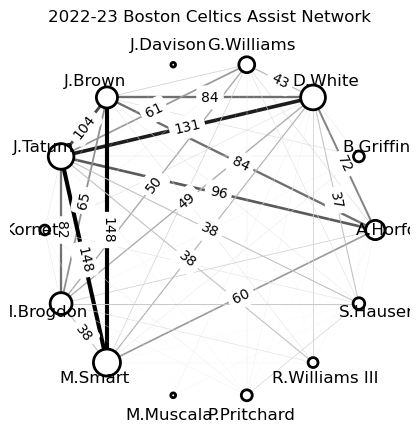

In [34]:
pass_web('BOS','2022-23','AST')

Retrieving from NBA Stats URL...
Data retrieved...


/var/folders/ds/8n3t559534xdjhwy7xq1h9nm0000gn/T/ipykernel_21504/914915468.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


[[0 6 0 3 5 1 3 15 1 5 4 4 5 3 0 4 13 2]
 [6 0 1 0 2 0 2 3 2 3 0 2 5 1 1 2 11 1]
 [0 1 0 0 4 0 44 36 15 39 0 35 8 4 0 6 0 11]
 [3 0 0 0 5 0 4 27 0 16 6 20 6 11 1 1 1 5]
 [5 2 4 5 0 1 15 33 4 17 1 10 29 6 5 2 5 3]
 [1 0 0 0 1 0 5 8 3 4 0 1 2 2 0 2 2 1]
 [3 2 44 4 15 5 0 79 16 66 4 110 35 38 1 22 3 44]
 [15 3 36 27 33 8 79 0 13 58 8 90 32 47 2 26 9 32]
 [1 2 15 0 4 3 16 13 0 4 0 6 6 22 0 3 0 4]
 [5 3 39 16 17 4 66 58 4 0 2 32 11 29 2 5 0 28]
 [4 0 0 6 1 0 4 8 0 2 0 9 9 0 1 0 4 0]
 [4 2 35 20 10 1 110 90 6 32 9 0 14 29 2 5 1 12]
 [5 5 8 6 29 2 35 32 6 11 9 14 0 27 2 20 0 14]
 [3 1 4 11 6 2 38 47 22 29 0 29 27 0 1 4 4 0]
 [0 1 0 1 5 0 1 2 0 2 1 2 2 1 0 1 0 0]
 [4 2 6 1 2 2 22 26 3 5 0 5 20 4 1 0 6 1]
 [13 11 0 1 5 2 3 9 0 0 4 1 0 4 0 6 0 1]
 [2 1 11 5 3 1 44 32 4 28 0 12 14 0 0 1 1 0]]


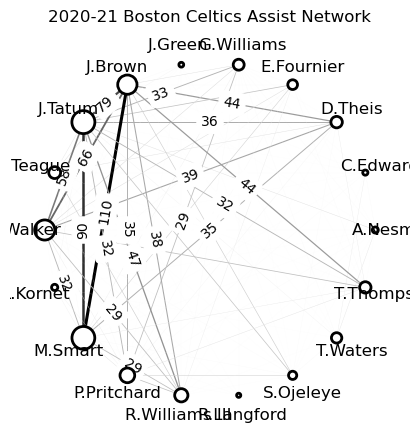

In [35]:
pass_web('BOS','2020-21','AST')

Retrieving from NBA Stats URL...
Data retrieved...


/var/folders/ds/8n3t559534xdjhwy7xq1h9nm0000gn/T/ipykernel_21504/448467005.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


[[0 6 590 439 688 447 110 35 10 19 396 131 2 8]
 [6 0 27 22 26 9 2 22 24 28 125 38 37 0]
 [590 27 0 1206 1749 895 918 224 41 104 497 377 24 58]
 [439 22 1206 0 802 789 679 115 18 63 400 199 2 29]
 [688 26 1749 802 0 1527 814 200 46 70 856 357 31 44]
 [447 9 895 789 1527 0 569 157 37 82 540 336 13 42]
 [110 2 918 679 814 569 0 11 0 28 217 82 9 6]
 [35 22 224 115 200 157 11 0 3 29 386 130 53 8]
 [10 24 41 18 46 37 0 3 0 15 140 37 31 2]
 [19 28 104 63 70 82 28 29 15 0 415 74 44 16]
 [396 125 497 400 856 540 217 386 140 415 0 735 303 152]
 [131 38 377 199 357 336 82 130 37 74 735 0 55 25]
 [2 37 24 2 31 13 9 53 31 44 303 55 0 17]
 [8 0 58 29 44 42 6 8 2 16 152 25 17 0]]


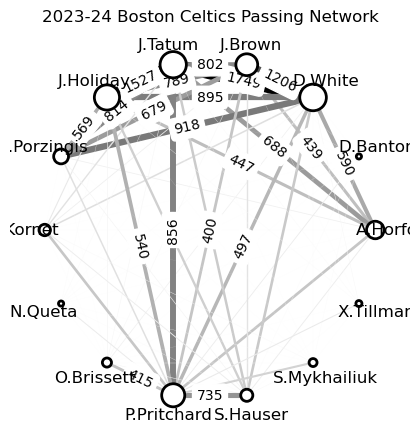

In [43]:
pass_web('BOS','2023-24','PASS')

Retrieving from NBA Stats URL...
Data retrieved...


/var/folders/ds/8n3t559534xdjhwy7xq1h9nm0000gn/T/ipykernel_21504/448467005.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  adf.values[[np.arange(adf.shape[0])]*2] = 0


[[0 39 10 17 41 11 44 139 30 92 17 89 176 33 12 20 113 26]
 [39 0 13 4 26 18 12 39 22 46 7 23 74 17 6 13 81 13]
 [10 13 0 0 26 0 327 407 156 529 0 362 170 11 0 53 9 50]
 [17 4 0 0 43 0 39 140 0 145 60 153 116 46 13 8 32 51]
 [41 26 26 43 0 12 162 350 173 274 30 260 403 73 26 19 72 59]
 [11 18 0 0 12 0 50 90 82 66 0 48 94 29 0 35 33 28]
 [44 12 327 39 162 50 0 628 230 644 35 827 402 257 17 121 55 340]
 [139 39 407 140 350 90 628 0 358 1125 66 1011 697 441 27 252 122 477]
 [30 22 156 0 173 82 230 358 0 72 0 174 156 166 0 131 2 130]
 [92 46 529 145 274 66 644 1125 72 0 54 691 146 223 32 229 0 412]
 [17 7 0 60 30 0 35 66 0 54 0 82 149 0 23 10 31 0]
 [89 23 362 153 260 48 827 1011 174 691 82 0 244 273 45 161 3 377]
 [176 74 170 116 403 94 402 697 156 146 149 244 0 264 56 273 23 169]
 [33 17 11 46 73 29 257 441 166 223 0 273 264 0 10 48 27 0]
 [12 6 0 13 26 0 17 27 0 32 23 45 56 10 0 6 29 23]
 [20 13 53 8 19 35 121 252 131 229 10 161 273 48 6 0 65 43]
 [113 81 9 32 72 33 55 122 2 0 31 3 23 2

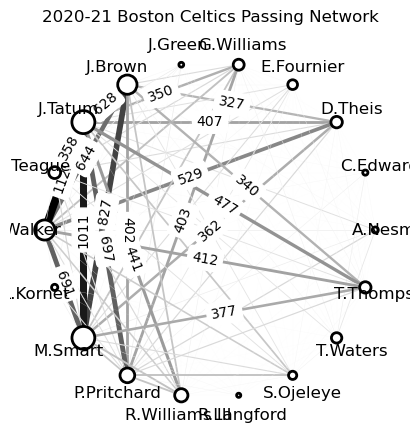

In [48]:
pass_web('BOS','2020-21','PASS')